In [9]:
import cv2

import numpy as np
import pandas as pd
from joblib import load, dump

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

# keras
np.random.seed(13)
from keras.models import Sequential
from keras.layers import (Dense, Embedding, Reshape, Activation, 
                          SimpleRNN, LSTM, Convolution1D, 
                          MaxPooling1D, Dropout, Bidirectional)
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop

nPoints = 18

KEYPOINTS = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16]]


pose_data_file = "../data/frames/forRNN_pose_by_daner.out"
pose_data_by_dancer = load(pose_data_file)

Using TensorFlow backend.
//anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/envs/metis/lib/python3.7/site-packages/tenso

In [112]:
dancers = len(pose_data_by_dancer)
X = []
y = []
seqLen = 48
slide = 2

for dancer in range(dancers):
    pose_coords = pose_data_by_dancer[dancer]
    poses = len(pose_coords)
    if poses<60:
        continue #go to next dancer
    
    for i in range(0, poses - seqLen, slide):
        X.append(pose_coords[i:i+seqLen])
        y.append(pose_coords[i+seqLen])

X = np.array(X)
y = np.array(y)

In [113]:
print(X.shape)
print(y.shape)

(16189, 48, 36)
(16189, 36)


In [116]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', min_delta = 0.01, patience=3, verbose=1)


# Model
print('Build model...')
salsa_model = Sequential()
salsa_model.add(LSTM(36, input_shape=(seqLen, 36), return_sequences=True))
salsa_model.add(LSTM(36, input_shape=(seqLen, 36), return_sequences=True))
salsa_model.add(LSTM(36, input_shape=(seqLen, 36), return_sequences=False))
salsa_model.add(Dense(36))
salsa_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
hist = salsa_model.fit(X, y, epochs=3, verbose=True, callbacks=[early_stopping])

#optimizer = RMSprop(lr=0.0

Build model...
Epoch 1/3
16189/16189 [==============================] - 51s 3ms/step - loss: 56884.4789 - mean_squared_error: 56884.4789
Epoch 2/3
16189/16189 [==============================] - 48s 3ms/step - loss: 49463.7432 - mean_squared_error: 49463.7432
Epoch 3/3
16189/16189 [==============================] - 48s 3ms/step - loss: 43133.6301 - mean_squared_error: 43133.6301


In [ ]:
#--- Early Stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])

#--- History
hist = model.fit(x, y, validation_split=0.2)
print(hist.history)


#--- Save a Keras Model
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

In [117]:
salsa_model.save("../models/threelayerLSTM.h5")

In [84]:
def plotSinglePose(posePoint):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 15]
        #ims = []
        #fig = plt.figure()
        
        imgArray = np.ones((640, 360))
        plt.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
        #ims.append([im])
        plt.axis('off')
        
        for pair in POSE_PAIRS:
            # Checking just xcoord for valid point is enough
            valid_pt1 = (posePoint[pair[0]][0] != -1)
            valid_pt2 = (posePoint[pair[1]][0] != -1)
            if valid_pt1 and valid_pt2:
                xs = [posePoint[pair[0]][0], posePoint[pair[1]][0]]
                ys = [posePoint[pair[0]][1], posePoint[pair[1]][1]]
                plt.plot(xs, ys,'ko-', linewidth=2)
                
        #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
        #                        repeat_delay=1000)
        plt.show()
def flat_to_pose(flatPose):
    pose_dim = flatPose.reshape((-1, 2))
    
    return {i:pose_dim[i].tolist() for i in range(0, len(pose_dim))}
    

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[286.50122  103.02738  306.72592  127.025986 294.20822  126.04297
  272.7802   135.54527  247.96451  127.32689  314.29102  125.89135
  305.73434  135.8601   278.83392  129.61736  300.1322   175.49721
  296.62933  211.67043  295.2863   246.5547   313.4236   175.56868
  312.7077   212.14215  310.18625  247.95113  259.6653    89.41908
  260.3943    89.88046  213.09673   74.09691  205.06467   73.79602 ]]


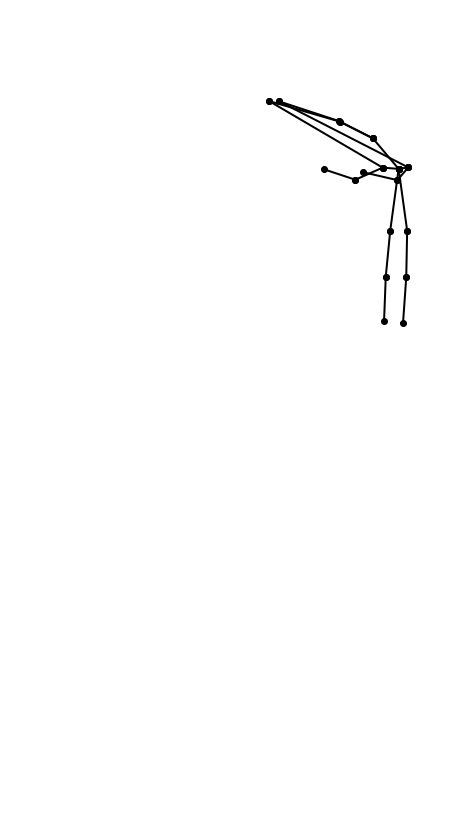

In [143]:
from keras.models import load_model
model_to_test = load_model("../models/twolayerLSTM.h5")

p = np.random.randint(0, 600)

x = np.array([pose_data_by_dancer[40][p: p+seqLen]])
x = x*0
y = model_to_test.predict(x)
print(x)
print(y)
plt.rcParams['figure.figsize'] = [30, 15]
plotSinglePose(flat_to_pose(y))

In [135]:
from itertools import product

act_funcs = ['relu', 'tanh']
layers = [2, 3]
epochs = range(100, 250, 50)

for item in product(act_funcs, layers, epochs):
    print(item)

    
def salsa_model_template(item):
    """
    item is tuple (activation, no of layers, epochs)
    """
    
    
    
    

('relu', 2, 100)
('relu', 2, 150)
('relu', 2, 200)
('relu', 3, 100)
('relu', 3, 150)
('relu', 3, 200)
('tanh', 2, 100)
('tanh', 2, 150)
('tanh', 2, 200)
('tanh', 3, 100)
('tanh', 3, 150)
('tanh', 3, 200)
